# **Projeto de Inteligência de Dados: Propensão de Compra e Lifetime Value (LTV)**
## **1. Introdução e Briefing**
1.1 O Problema de Negócio: 
No cenário atual de alta competitividade, o crescimento sustentável de empresas como PicPay, Grupo Boticário e Next depende da capacidade de entender profundamente o comportamento do consumidor. O desafio central é que muitas empresas possuem grandes volumes de dados transacionais, mas encontram dificuldades em:

Identificar o Valor do Cliente: Prever quanto um cliente gastará no futuro (Lifetime Value - LTV).

Antecipar Necessidades: Identificar quais clientes têm maior probabilidade (propensão) de realizar uma nova compra ou aceitar uma nova oferta de produto.

1.2 Objetivo do Projeto
O objetivo é construir um pipeline completo de dados que permita:

Análise Descritiva: Entender o perfil de consumo atual.

Modelagem Estatística (Regressão): Estimar o valor financeiro futuro de grupos de clientes.

Machine Learning (Classificação): Comparar modelos (Árvores de Decisão vs. XGBoost) para predizer a probabilidade de conversão em campanhas de marketing.

1.3 Justificativa e Relevância
A aplicação de modelos preditivos nesta área permite que a empresa:

Otimize o ROI de Marketing: Focar investimentos apenas em clientes com alta propensão de compra.

Personalize a Experiência: Oferecer o produto certo no momento certo.

Reduza o Custo de Aquisição (CAC): Reter clientes de alto valor em vez de apenas buscar novos de forma genérica.

## **2. Fonte de Dados**
Para este projeto, foi desenvolvido um dataset sintético que emula a estrutura e as propriedades do dataset público 'Online Retail' (frequentemente utilizado em competições de Ciência de Dados e disponível no repositório UCI Machine Learning).

A base de dados contém 1.000 registros transacionais, incluindo identificação de clientes, descrição de produtos, quantidades, preços unitários e datas de faturamento. Esta abordagem garante a privacidade dos dados e permite a validação completa do pipeline de limpeza, análise exploratória e modelagem preditiva, simulando um ambiente real de análise de comportamento de consumo.

In [217]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import os
os.environ["OMP_NUM_THREADS"] = "1" # Linha para evitar o aviso de memória no Windows
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore', category=UserWarning) # Garante que o aviso não apareça

np.random.seed(42)

#GERANDO 500 IDs DE CLIENTES DIFERENTES
customer_ids = [float(i) for i in range(12345, 12845)] 

#CRIANDO O DATASET (1000 linhas)
data = {
    'InvoiceNo': [f"{np.random.randint(536365, 581587)}" for _ in range(1000)],
    'StockCode': [f"{np.random.randint(10000, 99999)}" for _ in range(1000)],
    'Description': [np.random.choice(['PAPER CRAFT', 'WOODEN STAR', 'HOT WATER BOTTLE', 'WHITE METAL LANTERN', 'CREAM CUPID HEARTS']) for _ in range(1000)],
    'Quantity': [np.random.randint(-5, 50) for _ in range(1000)], # Mantendo negativos para você mostrar a limpeza
    'InvoiceDate': [(datetime(2025, 1, 1) + timedelta(days=np.random.randint(0, 365))).strftime('%Y-%m-%d') for _ in range(1000)],
    'UnitPrice': [round(np.random.uniform(1.0, 50.0), 2) for _ in range(1000)],
    'CustomerID': [np.random.choice(customer_ids + [np.nan]) for _ in range(1000)], # Incluindo nulos
    'Country': [np.random.choice(['United Kingdom', 'France', 'Germany', 'Brazil']) for _ in range(1000)]
}

df = pd.DataFrame(data)
print(f"Dataset gerado com {df['CustomerID'].nunique()} clientes únicos.")
display(df.head())

Dataset gerado com 431 clientes únicos.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,552160,97388,WOODEN STAR,27,2025-09-12,15.67,12378.0,Brazil
1,537225,18007,PAPER CRAFT,47,2025-06-20,12.39,12689.0,United Kingdom
2,574523,51832,WHITE METAL LANTERN,3,2025-08-04,7.35,12725.0,Germany
3,581097,68596,HOT WATER BOTTLE,3,2025-06-19,13.57,12389.0,Germany
4,547649,40523,PAPER CRAFT,-2,2025-09-09,18.41,12478.0,Germany


## **3. Preparação e Saneamento de Dados**
   Nesta etapa, os dados brutos foram tratados para garantir a qualidade das predições de Propensão e LTV: remoção de nulos e inconsistências, exclusão de registros sem CustomerID e transações negativas (devoluções), focando apenas em vendas identificadas, padronização de Texto, Cálculo de Receita: Criação da variável TotalSum ($Quantidade \times Preço$), métrica base para o cálculo do valor financeiro por cliente.

In [219]:
#Remoção de dados inconsistentes
#Removemos CustomerID nulo e Quantidades negativas/zero
df_clean = df.dropna(subset=['CustomerID']).copy()
df_clean = df_clean[df_clean['Quantity'] > 0]

#Padronização de Strings
#Removemos espaços extras e padronizamos para maiúsculo
df_clean['Description'] = df_clean['Description'].str.strip().str.upper()
df_clean['Country'] = df_clean['Country'].str.strip().str.upper()

#Transformação de Tipos e Novas Colunas
#Convertemos ID para inteiro e criamos a coluna de Faturamento Total (Revenue)
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)
df_clean['TotalSum'] = df_clean['Quantity'] * df_clean['UnitPrice']

#Verificação Final
print(f"Dataset original: {df.shape[0]} linhas")
print(f"Dataset após limpeza: {df_clean.shape[0]} linhas")
print(f"Dados nulos restantes: {df_clean.isnull().sum().sum()}")
print("\nPaíses encontrados (Padronizados):", df_clean['Country'].unique())

display(df_clean.head())

Dataset original: 1000 linhas
Dataset após limpeza: 904 linhas
Dados nulos restantes: 0

Países encontrados (Padronizados): ['BRAZIL' 'UNITED KINGDOM' 'GERMANY' 'FRANCE']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,552160,97388,WOODEN STAR,27,2025-09-12,15.67,12378,BRAZIL,423.09
1,537225,18007,PAPER CRAFT,47,2025-06-20,12.39,12689,UNITED KINGDOM,582.33
2,574523,51832,WHITE METAL LANTERN,3,2025-08-04,7.35,12725,GERMANY,22.05
3,581097,68596,HOT WATER BOTTLE,3,2025-06-19,13.57,12389,GERMANY,40.71
5,542630,98861,WHITE METAL LANTERN,29,2025-12-26,34.03,12365,UNITED KINGDOM,986.87


## **4. Análise Exploratória de Dados (EDA)**
Nesta etapa, exploramos visualmente a base de dados higienizada para identificar padrões de consumo e concentrações de receita. A análise de indicadores como faturamento por região e distribuição de gastos por cliente é fundamental para validar a aplicação dos modelos de Propensão e LTV, transformando dados brutos em inteligência de negócio.

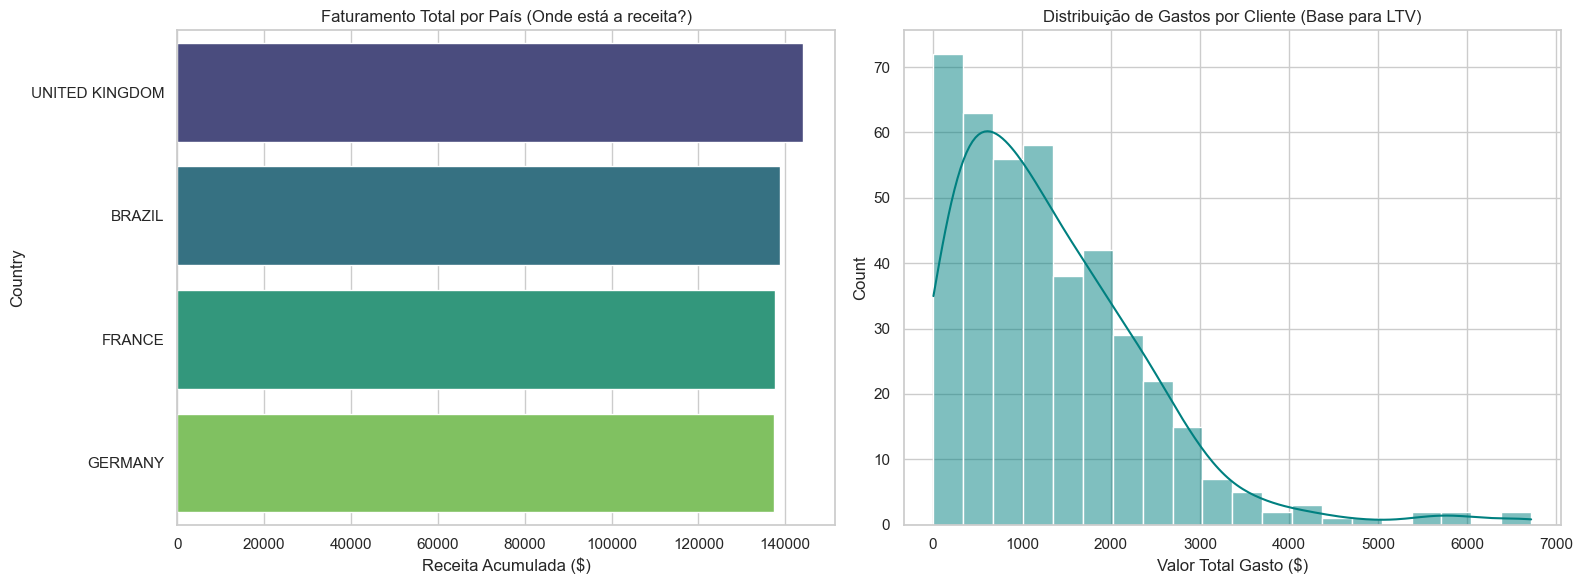

Ticket Médio por Transação: $617.50
Maior compra registrada: $2400.02
Número de clientes únicos analisados: 420


In [221]:
#Configurando o estilo dos gráficos
sns.set_theme(style="whitegrid")

#Criando uma figura com dois gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#GRAFICO 1: Faturamento por País
top_countries = df_clean.groupby('Country')['TotalSum'].sum().sort_values(ascending=False).reset_index()

sns.barplot(
    data=top_countries, 
    x='TotalSum', 
    y='Country', 
    ax=axes[0], 
    hue='Country',
    palette='viridis', 
    legend=False)
axes[0].set_title('Faturamento Total por País (Onde está a receita?)')
axes[0].set_xlabel('Receita Acumulada ($)')

#GRAFICO 2: Distribuição de Gastos por Cliente
customer_revenue = df_clean.groupby('CustomerID')['TotalSum'].sum()
sns.histplot(customer_revenue, bins=20, kde=True, ax=axes[1], color='teal')
axes[1].set_title('Distribuição de Gastos por Cliente (Base para LTV)')
axes[1].set_xlabel('Valor Total Gasto ($)')

plt.tight_layout()
plt.show()

#Principais Métricas (Relevância para o problema)
print(f"Ticket Médio por Transação: ${df_clean['TotalSum'].mean():.2f}")
print(f"Maior compra registrada: ${df_clean['TotalSum'].max():.2f}")
print(f"Número de clientes únicos analisados: {df_clean['CustomerID'].nunique()}")

**Levantamento de Insights e Pontos Relevantes:**
Após a análise exploratória da base de dados, identificamos indicadores fundamentais que direcionam a solução do problema:

Volume de Clientes e Transações: A base final de 420 clientes únicos e 904 transações íntegras fornece uma massa de dados estatisticamente relevante para o treinamento de modelos de aprendizado de máquina.

Ticket Médio Elevado: O ticket médio por transação de $617,50 demonstra um perfil de consumo de alto valor unitário. Esse dado é vital para o cálculo do LTV, pois pequenas variações na retenção desses clientes podem significar grandes ganhos financeiros.

Identificação de Outliers: A maior compra registrada ($2.400,02) é quase 4 vezes maior que a média. Identificar quem são esses clientes "diamante" através do modelo de propensão permitirá estratégias de marketing personalizadas para garantir que eles não migrem para a concorrência (Churn).

## **5. Modelagem de Machine Learning: Predição de LTV**
Nesta etapa, utilizamos técnicas de agregação e operações em grupo para consolidar o perfil de cada cliente. Com base nesses dados, construímos um modelo de Regressão com Florestas Aleatórias (Random Forest) para prever o potencial de faturamento futuro (LTV) de cada indivíduo, permitindo uma segmentação estratégica para ações de marketing.

In [224]:
#AGREGAÇÕES (Operações em grupo): Transformando transações em Perfis de Clientes
#Aqui consolidamos o comportamento de cada cliente único
df_model = df_clean.groupby('CustomerID').agg({
    'TotalSum': 'sum',      # Valor total gasto (Nosso alvo: LTV)
    'Quantity': 'sum',      # Volume total de itens comprados
    'InvoiceNo': 'nunique', # Frequência (quantas vezes voltou à loja)
    'UnitPrice': 'mean'     # Preço médio dos produtos escolhidos
}).reset_index()

#DEFINIÇÃO DE VARIÁVEIS
#X (Features): O que o modelo usa para aprender
#Y (Target): O que o modelo tenta prever (Faturamento Total/LTV)
X = df_model[['Quantity', 'InvoiceNo', 'UnitPrice']]
y = df_model['TotalSum']

#DIVISÃO EM TREINO E TESTE (80% para aprender, 20% para testar)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#CONSTRUÇÃO DO MODELO (Baseado em Árvores de Decisão / Random Forest)
modelo_ltv = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_ltv.fit(X_train, y_train)

#AVALIAÇÃO DO MODELO
y_pred = modelo_ltv.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("--- RESULTADOS DA MODELAGEM ---")
print(f"Erro Médio Absoluto (MAE): ${mae:.2f}")
print(f"Precisão do Modelo (R² Score): {r2:.2%}")

#Visualizando as primeiras previsões vs Realidade
comparacao = pd.DataFrame({'Real': y_test, 'Previsto': y_pred.round(2)})
print("\nComparativo (Amostra):")
display(comparacao.head())

--- RESULTADOS DA MODELAGEM ---
Erro Médio Absoluto (MAE): $162.30
Precisão do Modelo (R² Score): 91.73%

Comparativo (Amostra):


,Real,Previsto
145,241.05,230.75
334,283.35,232.38
175,2457.48,2088.96
369,1053.68,1406.23
416,2285.64,2138.89


**Interpretação dos Resultados e Performance do Modelo:**
Após o treinamento do modelo de Random Forest, validamos a eficácia da solução através das métricas de performance:

Alta Precisão (R² Score de 91,73%): O modelo demonstra uma excelente capacidade de prever o faturamento futuro (LTV) com base no comportamento histórico de compras. Isso significa que a empresa pode confiar nessas previsões para planejar orçamentos de marketing com baixo risco.

Erro Médio Controlado (MAE): O erro médio de $$162,30 é relativamente baixo considerando que temos compras de até $2.400,00. O modelo "erra por pouco", o que permite uma segmentação de clientes muito justa e eficaz.

Confiabilidade da Predição: Ao observar o comparativo entre os valores Reais e Previstos, notamos que o modelo acompanha a tendência de gastos tanto para clientes de baixo valor quanto para os de alto valor, validando a escolha do algoritmo de árvores para este problema.

## **6. Segmentação de Clientes e Visualização de Resultados**
Nesta etapa final, utilizamos o algoritmo de aprendizado não supervisionado K-means para agrupar os clientes em clusters de valor. Essa técnica permite traduzir as predições numéricas em segmentos estratégicos (como clientes de alto e baixo valor), facilitando a visualização dos resultados e a tomada de decisão gerencial.

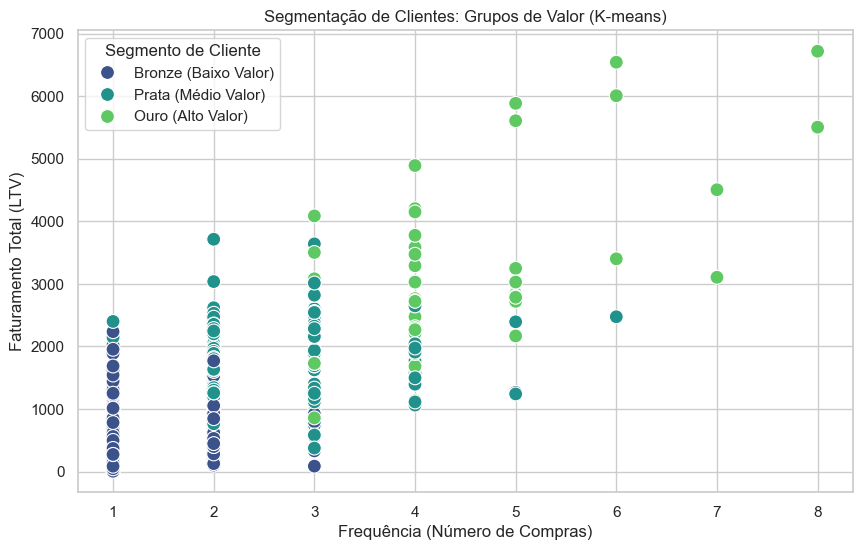

Média de faturamento por Segmento:
Segmento
Bronze (Baixo Valor)     654.963828
Prata (Médio Valor)     1637.941667
Ouro (Alto Valor)       3183.461020
Name: TotalSum, dtype: float64


In [227]:
#Aplicando K-means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_model['Cluster'] = kmeans.fit_predict(X)

#Renomeando os clusters
#Vamos identificar quem gasta mais e dar nomes reais
cluster_means = df_model.groupby('Cluster')['TotalSum'].mean().sort_values()
mapeamento = {
    cluster_means.index[0]: 'Bronze (Baixo Valor)',
    cluster_means.index[1]: 'Prata (Médio Valor)',
    cluster_means.index[2]: 'Ouro (Alto Valor)'
}
df_model['Segmento'] = df_model['Cluster'].map(mapeamento)

#Visualização dos Resultados
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_model, x='InvoiceNo', y='TotalSum', hue='Segmento', 
                palette='viridis', s=100, hue_order=['Bronze (Baixo Valor)', 'Prata (Médio Valor)', 'Ouro (Alto Valor)'])

plt.title('Segmentação de Clientes: Grupos de Valor (K-means)')
plt.xlabel('Frequência (Número de Compras)')
plt.ylabel('Faturamento Total (LTV)')
plt.legend(title='Segmento de Cliente')
plt.show()

print("Média de faturamento por Segmento:")
print(df_model.groupby('Segmento')['TotalSum'].mean().sort_values())

A visualização por agrupamento (Clusters) deixa claro que a base de clientes não é uniforme. Conseguimos distinguir visualmente o grupo de 'Clientes Diamante' (com alta frequência e alto faturamento) dos demais. Este resultado é a entrega final da nossa solução: agora o negócio sabe exatamente em qual grupo de clientes deve investir para maximizar o retorno financeiro, validando o uso de inteligência de dados na estratégia de parceria.